In [1]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt

from zipfile import ZipFile
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

def unzip(nm):
    with ZipFile(nm,"r") as zip:
        zip.extractall()

unzip("archive.zip")

Found 6484 files belonging to 11 classes.


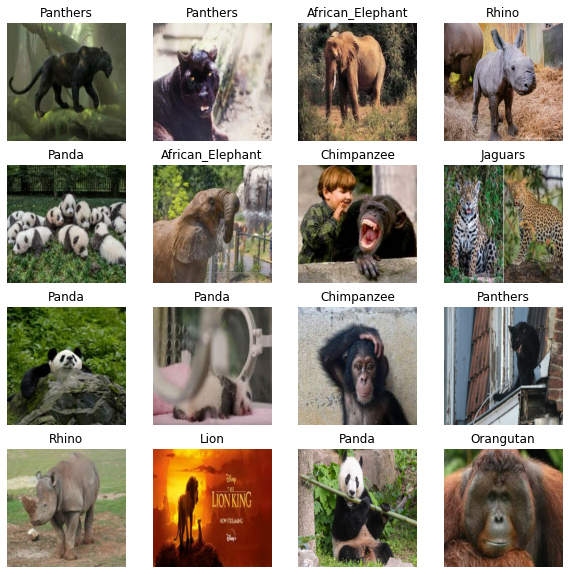

In [3]:
image = image_dataset_from_directory(
    directory = "Danger Of Extinction",
    seed = 42,
    shuffle = True,
    image_size = (224,224),
    batch_size = 32,
)

class_names = image.class_names

plt.figure(figsize=(10,10))
for images,labels in image.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    horizontal_flip = True,
    zoom_range = 0.1,
    rotation_range = 10,
    validation_split = 0.2,
)

train_ds = datagen.flow_from_directory(
    directory = "Danger Of Extinction",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True,
    subset = "training",
)

val_ds = datagen.flow_from_directory(
    directory = "Danger Of Extinction",
    target_size = (224,224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True,
    subset = "validation",
)

Found 5190 images belonging to 11 classes.
Found 1294 images belonging to 11 classes.


## Model == Transfer Learning (fine tuning) VGG16

In [5]:
from tensorflow.keras import Input, Model
from tensorflow.keras.applications import vgg16, VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

rescale = vgg16.preprocess_input
base_model = VGG16(input_shape=(224,224,3),include_top=False,weights="imagenet")
base_model.trainable = True

fine_tune_at = 10

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

class Transfer_VGG16():
    def model(self,input):
        self.x = rescale(input)
        self.x = base_model(self.x,training=False)
        self.x = GlobalAveragePooling2D()(self.x)
        self.x = Flatten()(self.x)
        self.x = Dense(128,activation="relu")(self.x)
        self.x = Dropout(0.2,seed=42)(self.x)
        self.x = Dense(64,activation="relu")(self.x)
        self.x = Dropout(0.2,seed=42)(self.x)
        self.output = Dense(11,activation="softmax")(self.x)
        self.model = Model(input,self.output,name="Transfer_VGG16")
        return self.model

TFVGG16 = Transfer_VGG16()
model = TFVGG16.model(Input(shape=(224,224,3)))
model.summary()
model.compile(Adam(1e-5),CategoricalCrossentropy(),metrics=["accuracy"])

Model: "Transfer_VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 128)            

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

if __name__=="__main__":
    checkpoint = ModelCheckpoint("animal.hdf5",save_weights_only=False,monitor="val_accuracy",save_best_only=True)
    model.fit(train_ds,epochs=20,validation_data=val_ds,callbacks=[checkpoint])
    best = load_model("animal.hdf5")
    val_loss,val_acc = best.evaluate(val_ds)
    print("\nVal acc: {:.2f} %".format(100*val_acc))
    print("Val loss: {:.2f} %".format(100*val_loss))

Epoch 1/20
163/163 [==============================] - 97s 524ms/step - loss: 2.4036 - accuracy: 0.2356 - val_loss: 1.3610 - val_accuracy: 0.5688
Epoch 2/20
163/163 [==============================] - 81s 494ms/step - loss: 1.2923 - accuracy: 0.5605 - val_loss: 0.6828 - val_accuracy: 0.7852
Epoch 3/20
163/163 [==============================] - 79s 484ms/step - loss: 0.8375 - accuracy: 0.7247 - val_loss: 0.5312 - val_accuracy: 0.8261
Epoch 4/20
163/163 [==============================] - 78s 479ms/step - loss: 0.6441 - accuracy: 0.7911 - val_loss: 0.4264 - val_accuracy: 0.8640
Epoch 5/20
163/163 [==============================] - 77s 474ms/step - loss: 0.5092 - accuracy: 0.8385 - val_loss: 0.3811 - val_accuracy: 0.8756
Epoch 6/20
163/163 [==============================] - 78s 479ms/step - loss: 0.4250 - accuracy: 0.8663 - val_loss: 0.3608 - val_accuracy: 0.8849
Epoch 7/20
163/163 [==============================] - 78s 479ms/step - loss: 0.3674 - accuracy: 0.8900 - val_loss: 0.3722 - val_ac